# Logical Ansatz Variational Quantum Linear Solver

This method is an adaption of the CQS method suggested in 
Hsin-Yuan Huang et al.  "Near-term quantum algorithms for linear systems of equations" (2019) [arXiv:1909.07344]

[Note the Python library 'cvxopt' is required to run this notebook]

In [1]:
#imports
import random
from math import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from scipy.optimize import minimize
import copy
import numpy as np
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

import parameterized_training_cqs_qasm as la

## Define Problem Variables

| | |
|-|-| 
|n_unitaries | number of unitaries used in the logical ansatz|
|unitary_depth| depth of the unitaries used in the logical ansatz|
|method| optimization method, from scipy.optimize.minimize|
|options| optimization options dictionary, from scipy.optimize.minimize| 
|n_training_rounds | number of logical ansatz training rounds |
|n_qubits| number of qubits in the problem specification| 

In [2]:
#PROBLEM VARIABLES
n_unitaries = 2  #Number of random unitaries used in the solution, x = a_1.x_1 + ... + a_n.x_n
unitary_depth = 1  #Depth of the random unitaries, depth 1 means one row of U3 gates, depth > 1 introduces random CX gates too
method = "COBYLA"  #Optimization method (scipy minimize), alternatives => Powell, Nelder-Mead
options = {'rhobeg':pi ,'maxiter':500}  #Optimization options (scipy minimize)
n_training_rounds = 1 #Number of training rounds 
n_qubits = 3

## Specify the Problem

Specifying the problem involves giving the number of qubits, and giving the relevant linear system $A\vec{x} = \vec{b}$ to be solved.

$A$ is a $2^n \times 2^n$ matrix given as a linear combination of $k$ unitary matrices $A = \Sigma_i c_iA_i$. 

n_qubits = $n$ if  $A$ is a $2^n \times 2^n$ matrix

The values for $c_i$ are given in the coefficient list, $[c_0, ..., c_k]$.

The unitaries $A_i$, of size $2^n \times 2^n$, are given as controlled versions of their respective quantum gates, with the idx value in the create_state_A_i function corresponding to the coefficent in the coefficent list at that same idx value, $c_{idx}$.

The control bit is assumed to be qubit 0, while the $A_i$ is to take up the $n$ qubits from $[1, ..., n]$. See diagram below for clarity.

$\vec{b}$ is given as a quantum state $|b>$ which is implemented here as the controlled version of the unitary gate $U$ such that $|b> = U|0>$.

(Both $A_i$ and $U$ are implemented as controlled gates as per the cost function)

This example problem gives $A = I + 0.2 \cdot  X_1 Z_2 + 0.2 \cdot  X_1$ (Where $X_1$ denotes an $X$ gate applied to the 1st qubit, similarly for the rest. $I$ denotes the Identity matrix (size 8 x 8 in this example) )

In [3]:
#specific to problem
coefficients = [1, 0.2, 0.2]

def create_controlled_state_b(quantum_circuit, qubits):
    for i in qubits:
        quantum_circuit.ch(0,i)
        
def create_controlled_state_b_dg(quantum_circuit, qubits):
    create_controlled_state_b(quantum_circuit, qubits)
    
def create_state_A_i(quantum_circuit, idx):#assumed 0 is hadamard test ancilla
    if(idx == 0):
        None
    if(idx == 1):
        quantum_circuit.cx(0,1)
        quantum_circuit.cz(0,2)
    if(idx == 2):
        quantum_circuit.cx(0,1)          
        
def create_state_A_i_dg(quantum_circuit, idx):
    create_state_A_i(quantum_circuit, idx)

## Creating the Parameterized Unitaries
Here random parameterized circuits are instantiated, as the Random_Parameterized_Unitary class, and stored in a list. 

This idea could be adapted in the parameterized_training_cqs_qasm.py file, to create any sort of ansatz required. All that must be ensured is that all the same methods as in the Random_Parameterized_Unitary are included. 

In [4]:
parameterized_unitaries = []
for i in range(n_unitaries):
    parameterized_unitaries.append(la.Random_Parameterized_Unitary(n_qubits,unitary_depth))

print("Unitaries Used\n")
for i in parameterized_unitaries:
    print(i) #prints the unitaries as rows of gates in order


Unitaries Used

['RY', 'RY', 'RY']

['RY', 'RY', 'RY']



## Creating a Solver Object

CQS_Solver(parameterized_unitaries, controlled_state_b, controlled_state_b_dg, controlled_A_l, controlled_A_l_dg, unitary_coefficients, method, options)

| | |
|-|-|
|parameterized_unitaries|  a list of parameterized unitaries|
|controlled_state_b| function to create controlled version of $U$|
|controlled_state_b_dg| function to create controlled version of $U^\dagger$|
|controlled_A_l| function to create controlled version of unitary $A_i$|
|controlled_A_l_dg| function to create controlled version of unitary $A_i^\dagger$|
|unitary_coefficients| list of coefficients, $[c_0, ..., c_k]$|
|method| the optimization method from scipy.optimize.minimize, note no gradient function has been included here|
|options|The optimization options dictionary of the above method , the same as options in scipy.optimize.minimize.|

Once the CQS_Solver object is instantiated, the solve function with the argument $-1$ will approximate the solution to the linear system using the current values of the parameters in the parameterized unitaries. The argument -1 indicates that all parameterized unitaries making up the logical ansatz need to be evaluated in the cost function.

In [5]:
solver = la.CQS_Solver(n_qubits, parameterized_unitaries, create_controlled_state_b, create_controlled_state_b_dg, create_state_A_i, create_state_A_i_dg, coefficients, method, options)
solver.solve(-1)

print(solver.solution_cost())

0.40525621595826955


## Training

In order to train the logical ansatz, we have used the minimize_all function. This function tells the minimizer to treat the logical ansatz as a single ansatz and optimize its parameters accordingly. Setting flag to True tells the minimize_all function that the logical ansatz coefficents should be updated along with the parameterized unitary parameter selection during minimization. 

For example let $L$ denote the logical ansatz with $k$ parameterized ansatz circuits, and $[V_1(\theta_0), ..., V_n(\theta_k-1)]$ denote the circuits creating the parameterized unitaries. Then the logical ansatz is written as:

$L = \alpha_0V_0(\theta_0) + ... + \alpha_kV_k(\theta_{k-1})$.

Now, the solve(-1) call seen above optimizes the selection of the $\alpha_i$ parameters. 

If flag is set to True then all the $\alpha_0, ..., \alpha_{k-1}$ parameters are updated during the optimization of all the $\theta_0, ..., \theta_{k-1}$ parameters. 

The method minimize_all is not the only way to select ansatz parameters. The method: 

minimize(index, flag=False),

tells the minimizer to only vary the parameters of the ansatz associated with te index passed to it. Again flag can be set to true if $\alpha_0, ..., \alpha_{k-1}$ must be updates during minimization else it can be left as false if they must remain unchanged.

Lastly the method add_unitary_and_solve(new_unitary) can be used at any time to add a new unitary to the logical ansatz. 

Training Round 1
0.40525621595826955 []
0.3742060893112463 [0]
0.9787672530941222 [0]
0.91492633792989 [0]
0.34098571715535686 [0, 1]
0.315038752163191 [1]
0.23618028851527853 [1]
0.9327178832337836 [0, 1]
0.6292755491017811 [0, 1]
0.1372976520933147 [0, 1]
0.27538809053025237 [0, 1]
0.20066652291845904 [0, 1]
0.4901299487138634 [0, 1]
0.1426985422535416 [0, 1]
0.3114903690683012 [0, 1]
0.21292643698908426 [0, 1]
0.12988708138579286 [0, 1]
0.21859128406246892 [0, 1]
0.14325653350425357 [0, 1]
0.04259092597006863 [0, 1]
0.018719607108644194 [0, 1]
0.012718637627475654 [0, 1]
0.015074653721858886 [0, 1]
0.018268292947570534 [0, 1]
0.008606494882461362 [0, 1]
0.05835371039316681 [0, 1]
0.04365878112493688 [0, 1]
0.0035140139165199054 [0, 1]
0.012996129938340472 [0, 1]
0.009154865486089998 [0, 1]
0.006646960930051194 [0, 1]
0.008836480558901997 [0, 1]
0.005646307924598722 [0, 1]
0.005028743667505006 [0, 1]
0.00821059879167123 [0, 1]
0.006745162924565355 [0, 1]
0.005650018848702006 [0, 1]
0

/home/aidan/anaconda3/lib/python3.8/site-packages/qiskit/visualization/counts_visualization.py:239: ComplexWarning: Casting complex values to real discards the imaginary part
  values = np.array(values, dtype=float)


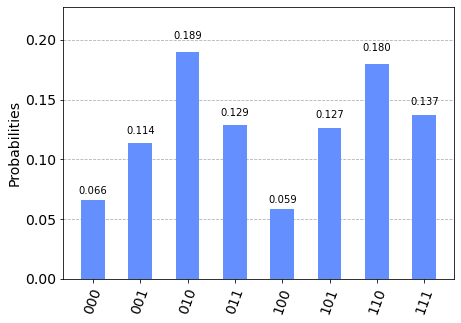

In [6]:
for i in range(n_training_rounds):
    print("Training Round {0}".format(i+1))
    solver.minimize_all(flag=True)
    solver.solve(-1)

q = solver.solution_cost()
print(q)

result = solver.return_solution_dictionary()
plot_histogram(result)